# Description

Runs spectral clustering on the umap version of the data.

# Environment variables

In [1]:
from IPython.display import display

import conf

N_JOBS = conf.GENERAL["N_JOBS"]
display(N_JOBS)

3

In [2]:
%env MKL_NUM_THREADS=$N_JOBS
%env OPEN_BLAS_NUM_THREADS=$N_JOBS
%env NUMEXPR_NUM_THREADS=$N_JOBS
%env OMP_NUM_THREADS=$N_JOBS

env: MKL_NUM_THREADS=3
env: OPEN_BLAS_NUM_THREADS=3
env: NUMEXPR_NUM_THREADS=3
env: OMP_NUM_THREADS=3


# Modules loading

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_result_set_name

# Settings

In [5]:
np.random.seed(0)

In [6]:
INITIAL_RANDOM_STATE = 50000

## Input data

In [7]:
INPUT_SUBSET = "umap"

In [8]:
INPUT_STEM = "z_score_std-projection-smultixcan-efo_partial-mashr-zscores"

In [9]:
DR_OPTIONS = {
    "n_components": 50,
    "metric": "euclidean",
    "n_neighbors": 15,
    "random_state": 0,
}

In [10]:
input_filepath = Path(
    conf.RESULTS["CLUSTERING_NULL_DIR"],
    "data_transformations",
    INPUT_SUBSET,
    generate_result_set_name(
        DR_OPTIONS, prefix=f"{INPUT_SUBSET}-{INPUT_STEM}-", suffix=".pkl"
    ),
).resolve()
display(input_filepath)

assert input_filepath.exists(), "Input file does not exist"

input_filepath_stem = input_filepath.stem
display(input_filepath_stem)

PosixPath('/opt/data/results/clustering/null_sims/data_transformations/umap/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0.pkl')

'umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores-metric_euclidean-n_components_50-n_neighbors_15-random_state_0'

## Clustering

In [11]:
from sklearn.cluster import SpectralClustering

In [12]:
CLUSTERING_ATTRIBUTES_TO_SAVE = ["n_clusters"]

In [13]:
CLUSTERING_OPTIONS = {}

CLUSTERING_OPTIONS["K_MIN"] = 2
CLUSTERING_OPTIONS["K_MAX"] = 60  # sqrt(3749)
CLUSTERING_OPTIONS["N_REPS_PER_K"] = 5
CLUSTERING_OPTIONS["KMEANS_N_INIT"] = 10
CLUSTERING_OPTIONS["GAMMA"] = 1.0e-02
CLUSTERING_OPTIONS["AFFINITY"] = "rbf"

display(CLUSTERING_OPTIONS)

{'K_MIN': 2,
 'K_MAX': 60,
 'N_REPS_PER_K': 5,
 'KMEANS_N_INIT': 10,
 'GAMMA': 0.01,
 'AFFINITY': 'rbf'}

In [14]:
CLUSTERERS = {}

idx = 0
random_state = INITIAL_RANDOM_STATE

for k in range(CLUSTERING_OPTIONS["K_MIN"], CLUSTERING_OPTIONS["K_MAX"] + 1):
    for i in range(CLUSTERING_OPTIONS["N_REPS_PER_K"]):
        clus = SpectralClustering(
            eigen_solver="arpack",
            n_clusters=k,
            n_init=CLUSTERING_OPTIONS["KMEANS_N_INIT"],
            affinity=CLUSTERING_OPTIONS["AFFINITY"],
            gamma=CLUSTERING_OPTIONS["GAMMA"],
            random_state=random_state,
        )

        method_name = type(clus).__name__
        CLUSTERERS[f"{method_name} #{idx}"] = clus

        random_state = random_state + 1
        idx = idx + 1

In [15]:
display(len(CLUSTERERS))

295

In [16]:
_iter = iter(CLUSTERERS.items())
display(next(_iter))
display(next(_iter))

('SpectralClustering #0',
 SpectralClustering(eigen_solver='arpack', gamma=0.01, n_clusters=2,
                    random_state=50000))

('SpectralClustering #1',
 SpectralClustering(eigen_solver='arpack', gamma=0.01, n_clusters=2,
                    random_state=50001))

In [17]:
clustering_method_name = method_name
display(clustering_method_name)

'SpectralClustering'

## Output directory

In [18]:
# output dir for this notebook
RESULTS_DIR = Path(
    conf.RESULTS["CLUSTERING_NULL_DIR"],
    "runs",
    f"{INPUT_SUBSET}-{INPUT_STEM}",
).resolve()
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

display(RESULTS_DIR)

PosixPath('/opt/data/results/clustering/null_sims/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores')

# Load input file

In [19]:
data = pd.read_pickle(input_filepath)

In [20]:
data.shape

(3752, 50)

In [21]:
data.head()

,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,UMAP6,UMAP7,UMAP8,UMAP9,UMAP10,...,UMAP41,UMAP42,UMAP43,UMAP44,UMAP45,UMAP46,UMAP47,UMAP48,UMAP49,UMAP50
100001_raw-Food_weight,7.464392,4.526705,4.225008,7.029216,4.382023,4.502639,4.489128,5.381521,4.940668,4.068273,...,7.605533,8.805881,8.939267,9.142330,0.445703,8.213864,0.703600,9.307579,4.072986,9.349484
100002_raw-Energy,7.429606,4.536586,4.182258,7.069884,4.336564,4.421313,4.560764,5.324892,4.929991,3.999348,...,7.583344,8.843954,8.958254,9.086064,0.390866,8.235448,0.706651,9.296489,4.041227,9.304544
100003_raw-Protein,7.481067,4.513837,4.172322,7.040905,4.395445,4.439210,4.487803,5.379720,4.935718,4.107790,...,7.619069,8.802183,8.938434,9.114165,0.442892,8.227354,0.692944,9.355126,4.053129,9.361687
100004_raw-Fat,7.383680,4.351026,4.208352,6.941895,4.375668,4.538863,4.477001,5.397546,5.008193,4.069299,...,7.592715,8.820724,8.919216,9.157578,0.454712,8.220077,0.721550,9.364523,4.043874,9.397904
100005_raw-Carbohydrate,7.412931,4.435416,4.227693,7.014967,4.406798,4.510470,4.479080,5.451272,4.932745,4.147858,...,7.606691,8.841007,8.881571,9.157351,0.409341,8.236560,0.724239,9.336825,4.040252,9.386523


In [22]:
assert not data.isna().any().any()

# Clustering

## Generate ensemble

In [23]:
from clustering.ensembles.utils import generate_ensemble

In [24]:
ensemble = generate_ensemble(
    data,
    CLUSTERERS,
    attributes=CLUSTERING_ATTRIBUTES_TO_SAVE,
)

100%|██████████| 295/295 [12:21<00:00,  2.52s/it]


In [25]:
# the number should be close to 295 (the number of partitions generated by k-means/spectral clustering)
ensemble.shape

(295, 3)

In [26]:
ensemble.head()

,clusterer_params,partition,n_clusters
clusterer_id,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [27]:
ensemble["n_clusters"].value_counts().head()

60    5
16    5
28    5
27    5
26    5
Name: n_clusters, dtype: int64

In [28]:
ensemble_stats = ensemble["n_clusters"].describe()
display(ensemble_stats)

count    295.000000
mean      31.000000
std       17.058323
min        2.000000
25%       16.000000
50%       31.000000
75%       46.000000
max       60.000000
Name: n_clusters, dtype: float64

## Testing

In [29]:
assert ensemble_stats["min"] > 1

In [30]:
assert not ensemble["n_clusters"].isna().any()

In [31]:
assert ensemble.shape[0] == len(CLUSTERERS)

In [32]:
# all partitions have the right size
assert np.all(
    [part["partition"].shape[0] == data.shape[0] for idx, part in ensemble.iterrows()]
)

In [33]:
# no partition has negative clusters (noisy points)
assert not np.any([(part["partition"] < 0).any() for idx, part in ensemble.iterrows()])

## Add clustering quality measures

In [34]:
from sklearn.metrics import calinski_harabasz_score

In [35]:
ensemble = ensemble.assign(
    ch_score=ensemble["partition"].apply(lambda x: calinski_harabasz_score(data, x))
)

In [36]:
ensemble.shape

(295, 4)

In [37]:
ensemble.head()

,clusterer_params,partition,n_clusters,ch_score
clusterer_id,,,,
SpectralClustering #0,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,2020.603782
SpectralClustering #1,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,2020.603782
SpectralClustering #2,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2,2020.603782
SpectralClustering #3,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,2020.603782
SpectralClustering #4,"{'affinity': 'rbf', 'assign_labels': 'kmeans',...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,2020.489300


## Save

In [38]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/SpectralClustering-AFFINITY_rbf-GAMMA_001-KMEANS_N_INIT_10-K_MAX_60-K_MIN_2-N_REPS_PER_K_5.pkl')

In [39]:
ensemble.to_pickle(output_filename)

# Cluster quality

In [40]:
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    _df = ensemble.groupby(["n_clusters"]).mean()
    display(_df)

,ch_score
n_clusters,
2,2020.580885
3,2596.711475
4,3005.419784
5,3073.083553
6,3012.573260
7,2902.489944
8,2875.778339
9,3076.165493
10,3239.017261


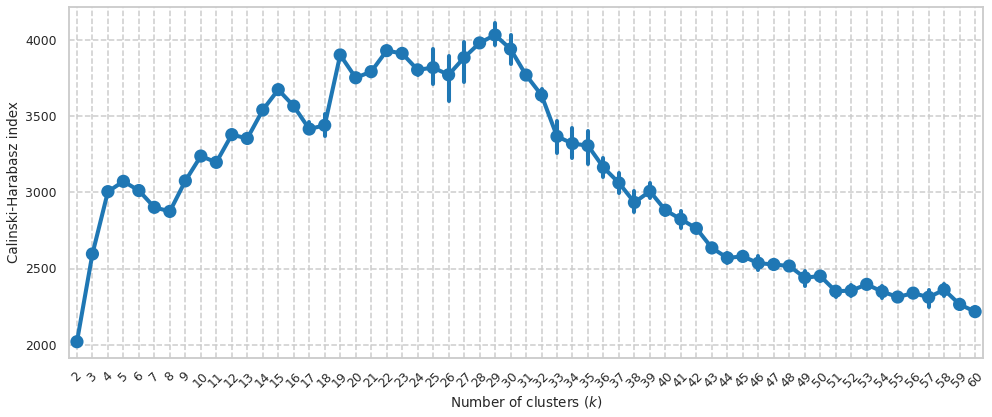

In [41]:
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=ensemble, x="n_clusters", y="ch_score")
    ax.set_ylabel("Calinski-Harabasz index")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    plt.grid(True)
    plt.tight_layout()

# Stability

## Group ensemble by n_clusters

In [42]:
parts = ensemble.groupby("n_clusters").apply(
    lambda x: np.concatenate(x["partition"].apply(lambda x: x.reshape(1, -1)), axis=0)
)

In [43]:
parts.head()

n_clusters
2    [[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,...
3    [[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0,...
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
5    [[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0,...
6    [[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0,...
dtype: object

In [44]:
assert np.all(
    [
        parts.loc[k].shape == (CLUSTERING_OPTIONS["N_REPS_PER_K"], data.shape[0])
        for k in parts.index
    ]
)

## Compute stability

In [45]:
from sklearn.metrics import adjusted_rand_score as ari
from scipy.spatial.distance import pdist

In [46]:
parts_ari = pd.Series(
    {k: pdist(parts.loc[k], metric=ari) for k in parts.index}, name="k"
)

In [47]:
parts_ari_stability = parts_ari.apply(lambda x: x.mean())
display(parts_ari_stability.sort_values(ascending=False).head(15))

4     1.000000
3     0.999671
2     0.999573
7     0.999127
5     0.998732
8     0.997828
6     0.997559
11    0.997391
12    0.996654
10    0.994210
19    0.990837
16    0.989379
9     0.988938
13    0.985257
15    0.976473
Name: k, dtype: float64

In [48]:
parts_ari_df = pd.DataFrame.from_records(parts_ari.tolist()).set_index(
    parts_ari.index.copy()
)

In [49]:
parts_ari_df.shape

(59, 10)

In [50]:
assert (
    int(
        (CLUSTERING_OPTIONS["N_REPS_PER_K"] * (CLUSTERING_OPTIONS["N_REPS_PER_K"] - 1))
        / 2
    )
    == parts_ari_df.shape[1]
)

In [51]:
parts_ari_df.head()

,0,1,2,3,4,5,6,7,8,9
2,1.00000,1.000000,1.000000,0.998933,1.000000,1.000000,0.998933,1.000000,0.998933,0.998933
3,1.00000,1.000000,0.999177,1.000000,1.000000,0.999177,1.000000,0.999177,1.000000,0.999177
4,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,0.99753,0.997530,0.996833,0.997530,1.000000,0.999300,1.000000,0.999300,1.000000,0.999300
6,0.99728,0.998652,0.998652,0.996570,0.995932,0.995932,0.999290,1.000000,0.996641,0.996641


## Save

In [52]:
output_filename = Path(
    RESULTS_DIR,
    generate_result_set_name(
        CLUSTERING_OPTIONS,
        prefix=f"{clustering_method_name}-stability-",
        suffix=".pkl",
    ),
).resolve()
display(output_filename)

PosixPath('/opt/data/results/clustering/null_sims/runs/umap-z_score_std-projection-smultixcan-efo_partial-mashr-zscores/SpectralClustering-stability-AFFINITY_rbf-GAMMA_001-KMEANS_N_INIT_10-K_MAX_60-K_MIN_2-N_REPS_PER_K_5.pkl')

In [53]:
parts_ari_df.to_pickle(output_filename)

## Stability plot

In [54]:
parts_ari_df_plot = (
    parts_ari_df.stack()
    .reset_index()
    .rename(columns={"level_0": "k", "level_1": "idx", 0: "ari"})
)

In [55]:
parts_ari_df_plot.dtypes

k        int64
idx      int64
ari    float64
dtype: object

In [56]:
parts_ari_df_plot.head()

,k,idx,ari
0,2,0,1.000000
1,2,1,1.000000
2,2,2,1.000000
3,2,3,0.998933
4,2,4,1.000000


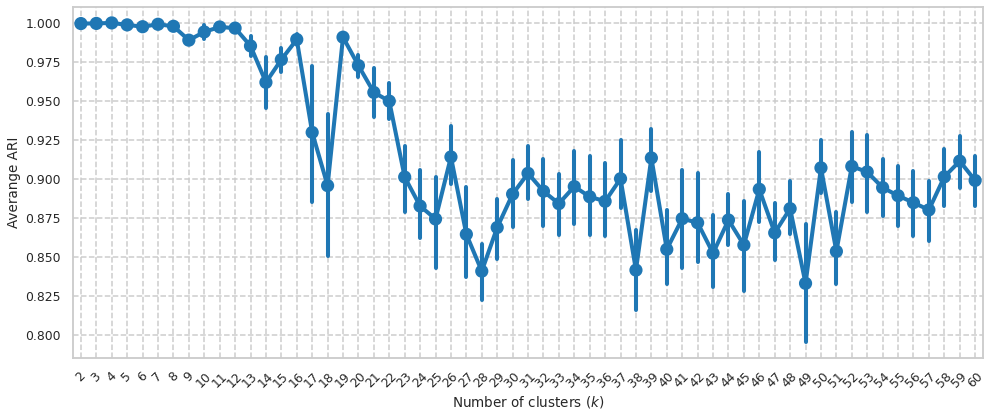

In [57]:
# with sns.axes_style('whitegrid', {'grid.linestyle': '--'}):
with sns.plotting_context("talk", font_scale=0.75), sns.axes_style(
    "whitegrid", {"grid.linestyle": "--"}
):
    fig = plt.figure(figsize=(14, 6))
    ax = sns.pointplot(data=parts_ari_df_plot, x="k", y="ari")
    ax.set_ylabel("Averange ARI")
    ax.set_xlabel("Number of clusters ($k$)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    #     ax.set_ylim(0.0, 1.0)
    #     ax.set_xlim(CLUSTERING_OPTIONS['K_MIN'], CLUSTERING_OPTIONS['K_MAX'])
    plt.grid(True)
    plt.tight_layout()